In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from bioinfokit import analys, visuz
from tqdm import tqdm
from scipy import stats

In [2]:
results_path = os.path.join('computed_stats', 'kruskal_AFR_EUR.csv')

# Load data
results = pd.read_csv(results_path)
results = results.drop(columns = ['Unnamed: 0'])

# Drop STRs where all populations had the same repeat count
results = results.dropna().reset_index(drop=True)

# Correct p-values
results['kruskal_pval_bonf'] = results.kruskal_pval * len(results)
results['kruskal_pval_bonf'].where(results['kruskal_pval_bonf'] < 1, 1, inplace=True) #Replace p-values larger than 1
results

,chr,position,motif_len,kruskal_statistic,kruskal_pval,kruskal_pval_bonf
0,chr1,899025,1,11.974592,5.393089e-04,1.000000e+00
1,chr1,902774,1,330.273090,8.381236e-74,9.953757e-68
2,chr1,904654,3,49.838430,1.669419e-12,1.982642e-06
3,chr1,907237,1,193.027823,6.941438e-44,8.243819e-38
4,chr1,907539,1,281.932787,2.847170e-63,3.381368e-57
...,...,...,...,...,...,...
1187619,chr22,50710846,2,1.412975,2.345632e-01,1.000000e+00
1187620,chr22,50732781,1,1.412131,2.347030e-01,1.000000e+00
1187621,chr22,50733151,3,2.127935,1.446355e-01,1.000000e+00
1187622,chr22,50735036,1,53.938783,2.068344e-13,2.456415e-07


In [3]:
def analyse_freqs(freqs):
    if freqs == ".":
        return np.nan, np.nan, np.nan
    freqs = freqs.split(",")
    freqs = [freq.split(":") for freq in freqs]
    allele_lens = []
    all_allele_len = []
    for freq in freqs:
        all_allele_len.append(len(freq[0]) * float(freq[1])) # appending len(allele)* frequency(allelec)
        if float(freq[1]) > 0.01:
            allele_lens.append(len(freq[0]))
    
    
    if len(allele_lens) == 0:
        return np.nan, np.nan, np.nan
    return np.sum(all_allele_len), np.max(allele_lens), np.min(allele_lens)


dir_addr = "/expanse/projects/gymreklab/helia/ensembl/experiments/charact/diff_dist/heterozygosity"
AFR_df = pd.DataFrame(columns = ['chrom','start', 'end', 'afreq-1', 'mean', 'max', 'min'])
EUR_df = pd.DataFrame(columns = ['chrom','start', 'end', 'afreq-1', 'mean', 'max', 'min'])
for chrom in tqdm(range(1,23)):
    AFR_het = pd.read_csv(f'{dir_addr}/coding_het_AFR_{chrom}.tab', sep = "\t") 
    AFR_het = AFR_het.drop(columns = ['mean-1'])
    AFR_het[['mean', 'max', 'min']] = AFR_het.apply(lambda row: analyse_freqs(row['afreq-1'])
                                                    , axis=1, result_type="expand")
    
    EUR_het = pd.read_csv(f'{dir_addr}/coding_het_EUR_{chrom}.tab', sep = "\t") 
    EUR_het = EUR_het.drop(columns = ['mean-1'])
    EUR_het[['mean', 'max', 'min']] = EUR_het.apply(lambda row: analyse_freqs(row['afreq-1'])
                                                    , axis=1, result_type="expand")
    
    
    AFR_df = pd.concat([AFR_df, AFR_het])    
    EUR_df = pd.concat([EUR_df, EUR_het])

100%|██████████| 22/22 [04:21<00:00, 11.90s/it]


In [5]:
both_pop = pd.merge(AFR_df, EUR_df, on = ["chrom",'start','end'], suffixes = ["_AFR", "_EUR"])
both_pop = pd.merge(both_pop, results, left_on = ['chrom', 'start'], right_on = ['chr', 'position'])
both_pop['mean_dif'] = (both_pop['mean_AFR'] - both_pop['mean_EUR']) / both_pop['motif_len']
both_pop['max_dif'] = (both_pop['max_AFR'] - both_pop['max_EUR']) / both_pop['motif_len']
both_pop['min_dif'] = (both_pop['min_AFR'] - both_pop['min_EUR']) / both_pop['motif_len']

both_pop = both_pop.dropna()

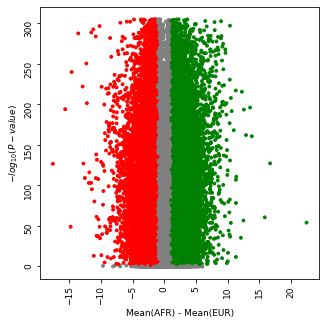

In [58]:
# visuz.GeneExpression.volcano(df=both_pop, lfc='max_dif', pv='kruskal_pval_bonf', axxlabel="Max(AFR) - Max(EUR)", figname=f"plots/max_dif", r = 700)
# visuz.GeneExpression.volcano(df=both_pop, lfc='min_dif', pv='kruskal_pval_bonf', axxlabel="Min(AFR) - Min(EUR)", figname=f"plots/min_dif", r = 700)
visuz.GeneExpression.volcano(df=both_pop, lfc='mean_dif', pv='kruskal_pval_bonf', axxlabel="Mean(AFR) - Mean(EUR)", show=True)


<ipython-input-8-1027af4b9e76>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant['gene'] = significant.apply(lambda row: find_genes(row), axis = 1)
/cm/shared/apps/spack/gpu/opt/spack/linux-centos8-skylake_avx512/gcc-8.3.1/anaconda3-2020.11-bsn4npoxyw7jzz7fajncek3bvdoaa5wv/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


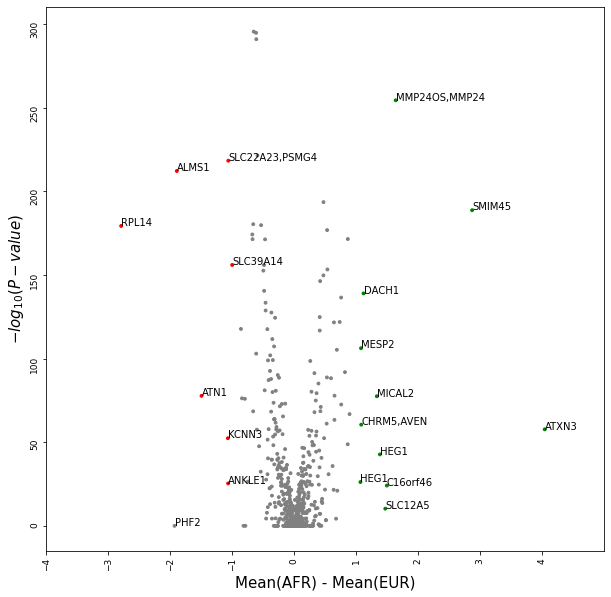

In [8]:
## Coding regions

coding_TRs = pd.read_csv("../stats/coding_overlap/TR_intersect.txt", sep = "\t", header=None)
coding_diff = pd.merge(both_pop, coding_TRs, left_on = ["chr","position"], right_on=[0,1])


significant = coding_diff[coding_diff['mean_dif'].abs() > 1]

# genes = pd.read_csv("Homo_sapiens.GRCh38.108.gtf", sep = "\t", comment="#", header=None)
# genes[0] = "chr" + genes[0].astype(str)


def find_genes(row):
    gene_df = genes[(genes[0] == row['chr']) & (genes[3] <= row['position']) & 
                    (genes[4] >= row['position'])]
    if len(gene_df) == 0:
        return None
    gene_df_info = gene_df[8].str.split(";")
    gene_set = set()
    for info in list(gene_df_info):
        for field in info:
            if "gene_name" in field:
                name = field.strip().replace("gene_name ","").replace('"','')
                gene_set.add(name)
    if len(gene_set) == 0:
        return None
                
    return ",".join(list(gene_set))

significant['gene'] = significant.apply(lambda row: find_genes(row), axis = 1)

visuz.GeneExpression.volcano(df=coding_diff, lfc='mean_dif', pv='kruskal_pval_bonf', dim = (10,10),
                             axxlabel="Mean(AFR) - Mean(EUR)", geneid = 'start', gfont=10,
                            genenames=pd.Series(significant.gene.values,index=significant.position).to_dict(),
                            axlabelfontsize=15, xlm=(-4,5,1), figname=f"plots/AFR_vs_EUR", show = True)

In [94]:
### Pathogenic loci

import warnings
warnings.filterwarnings('ignore')


both_pop = both_pop[['chrom','start','end', 'mean_dif','motif_len']]
pathogenic_loci = pd.read_csv("1000GenomesRepeatValidationDatabase - loci.csv", sep = ",")
pathogenic_loci = pathogenic_loci[pathogenic_loci['LocusType'].isin(['PathogenicSTR', 'PathogenicVNTR'])]
pathogenic_df = pd.DataFrame(columns = ['chrom','start','end', 'mean_dif', 'LocusID', 
                                        'LocusType', 'Motif', 'oldStart', 'oldEnd'])

for index, row in pathogenic_loci.iterrows():
    candid_locus = both_pop[(both_pop['start'] > row['Start'] - 100) & (both_pop['start'] < row['Start'] + 100) &
                           (both_pop['motif_len'] == len(row['Motif'])) & (both_pop['chrom'] == row['Chrom'])]
    if len(candid_locus) < 1:
        print(f"{row['LocusID']} was not found.")
        continue
    elif len(candid_locus) > 1:
        print(f"More than 1 candid for {row['LocusID']}")
        candid_locus['oldStart'] = row['Start']
        candid_locus['oldEnd'] = row['End']
        candid_locus['LocusID'] = row['LocusID']
        candid_locus['LocusType'] = row['LocusType']
        candid_locus['Motif'] = row['Motif']
        pathogenic_df = pd.concat([pathogenic_df, candid_locus[candid_locus['start'] == row['Start']]])
    else:
        candid_locus['oldStart'] = row['Start']
        candid_locus['oldEnd'] = row['End']
        candid_locus['LocusID'] = row['LocusID']
        candid_locus['LocusType'] = row['LocusType']
        candid_locus['Motif'] = row['Motif']
        pathogenic_df = pd.concat([pathogenic_df, candid_locus])

pathogenic_df = pathogenic_df.drop(columns = 'motif_len')
pathogenic_df.columns = ['chrom','start','end', 'Mean_AFR - Mean_EUR', 'LocusID', 
                                        'LocusType', 'Motif', 'oldStart', 'oldEnd']
        
pathogenic_df.sort_values('Mean_AFR - Mean_EUR').reset_index(drop = True).to_csv("Pathogenic_AFR_vs_EUR.csv", 
                                                                                 sep = ",", index = False)

More than 1 candid for ATXN7
CNBP was not found.
FOXL2 was not found.
RUNX2 was not found.
FXN was not found.
PAPBN1 was not found.
AFF2 was not found.
AR was not found.
ARX was not found.
PER3 was not found.
MUC1 was not found.
